In [27]:
import warnings
import pandas as pd
from sklearn.preprocessing import MinMaxScaler , StandardScaler , RobustScaler

# Ignore warnings
warnings.filterwarnings('ignore')

In [28]:
df = pd.read_csv("flat_file3.csv" , index_col=False)
df = df.dropna()

In [29]:
df = df.drop('restaurant_name', axis=1)

In [30]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Define the target and feature set
total_samples = df.shape[0]
display(df.head())

X = df.loc[:,df.columns != 'high_rated_popular']
y = df['high_rated_popular']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.2, random_state=5)



,claimed,price_level,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,working_shifts_per_week,Certificate of Excellence 2011,Certificate of Excellence 2012,Certificate of Excellence 2013,...,Street Parking,Table Service,Takeout,Television,Valet Parking,Validated Parking,Waterfront,Wheelchair Accessible,Wine and Beer,province_Code
1,1.0,3.0,0,0,0,5,10.0,0,0,0,...,1,0,0,0,0,0,0,0,0,55
5,1.0,2.0,0,0,0,5,5.0,0,0,0,...,1,0,1,0,0,0,0,1,1,41
6,1.0,2.0,0,0,0,6,8.0,0,0,0,...,0,1,0,0,0,0,0,0,0,14
11,1.0,2.0,1,0,0,7,12.0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
16,1.0,2.0,0,0,0,1,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,26


In [14]:
# Hyperparameter tuning for the models with GridSearchCV

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

results = []
names = []
best_params = []
models = {}


scores = ["recall" , "f1"]
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        results["mean_test_f1"],
        results["std_test_f1"],
        results["mean_test_recall"],
        results["std_test_recall"],
        results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()

# iterate and run all models
def execute_model(models_, X , y , scoring = 'f1', folds = 5 , random_state_id = 5):  
    for name, model, params in models_:
        kfold = KFold(n_splits=folds, random_state= random_state_id, shuffle=True)
        grid_search = GridSearchCV(model, params,cv = kfold, refit = True , scoring=scoring, verbose=0)
        grid_search.fit(X, y)
        #best_params.append(grid_search.best_params_)         
        results.append(grid_search.best_score_)
        names.append(name)
       # models[name]=grid_search.best_estimator_
                
    return names, results  , models


In [31]:
# Create Models parameters data

rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()
lr = LogisticRegression()
gbc = GradientBoostingClassifier()
adac = AdaBoostClassifier()
xgboostc = xgb.XGBClassifier()
gnb = GaussianNB()

models = [
    ('RF', rfc,{}),
    ('DTC', dtc,{}),
    ('LR', lr,{}),
    ('GB', gbc,{}),
    ('AdaBoostClassifier', adac,{}),
    ('XGBClassifier', xgboostc,{}),
    ('GaussianNB', gnb, {})]

 

In [16]:
hyperparameters_scoring='f1' # 'f1'
folds_number = 5
random_state_id = 5
names, results  , models  = execute_model(models, X_train , y_train, folds = folds_number, scoring=hyperparameters_scoring, random_state_id = random_state_id)

## Models Validation

In [23]:
for name, cv_result  , model  in zip(names, results , models):
    print(name)


RF
DTC
LR
GB
AdaBoostClassifier
XGBClassifier
GaussianNB


""


In [24]:

hyperparameter_tuning_scores_df = pd.DataFrame()
model_params_df = pd.DataFrame()

for name, cv_result  , model  in zip(names, results , models):        
        # handle the results (cross-validation scores)        
        dict = {'Model': name, 'Score': cv_result.round(3)}
        row = pd.DataFrame([dict])             
        hyperparameter_tuning_scores_df = pd.concat([hyperparameter_tuning_scores_df, row], axis=0)   


hyperparameter_tuning_scores_df.reset_index(drop=True, inplace=True)
hyperparameter_tuning_scores_df.sort_values(by='Score', ascending=False, inplace=True)



In [26]:
display(hyperparameter_tuning_scores_df.sort_values(by='Score', ascending=False))
display(model_params_df)

,Model,Score
5,XGBClassifier,0.870
3,GB,0.868
0,RF,0.866
2,LR,0.861
4,AdaBoostClassifier,0.859
6,GaussianNB,0.818
1,DTC,0.802


""


In [15]:
# prepare code  measuring performance of the models
from sklearn import metrics

def classificationMetrics(y, yhat):
    res = {'Accuracy': metrics.accuracy_score(y,yhat),
           'Precision': metrics.precision_score(y,yhat),
           'Recall': metrics.recall_score(y,yhat),
           'F1': metrics.f1_score(y,yhat),
           'AUC': metrics.roc_auc_score(y,yhat)
          }
    return res

In [16]:
import matplotlib.pyplot as plt

def test_model(model , model_name, X , y, models_perfmance_df):    
    lrtest_pred = model.predict(X)    # model is a best estimator from GridSearchCV 
    display(f"Performance metrics for {model_name} model")                              
    print(classification_report(y_test, lrtest_pred))
    mod1_dict = {'Model': model_name}
    new_row = pd.DataFrame([{**mod1_dict, **classificationMetrics(y, lrtest_pred) }])
    models_perfmance_df = pd.concat([models_perfmance_df, new_row], ignore_index=True)    
    cm = confusion_matrix(y, lrtest_pred)      
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    disp.ax_.set_title(f"Confusion Matrix for {model_name}")
    plt.rcParams['figure.figsize'] = [4, 3]
    plt.tight_layout()
    plt.show()    
    return models_perfmance_df


def validate_models(models_perfmance_df, X, y):
    # tests different models with best parameters from hyperparameter tuning and returns the performance metrics
    for model_name in models.keys():
        model_instance = models[model_name]      
        models_perfmance_df  = test_model(model_instance , model_name, X, y, models_perfmance_df)    

    models_perfmance_df.reset_index(drop=True, inplace=True)
    models_perfmance_df.set_index('Model', inplace=True)
    return models_perfmance_df

'Validation : models confusion matrixes:'

'Performance metrics for RF model'

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     10471
           1       0.88      0.86      0.87      5192

    accuracy                           0.91     15663
   macro avg       0.91      0.90      0.90     15663
weighted avg       0.91      0.91      0.91     15663



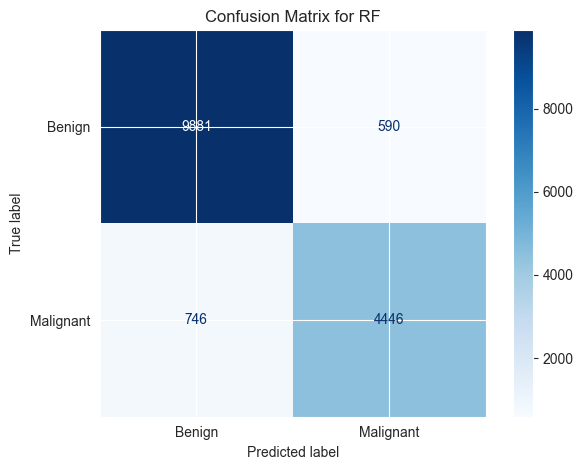

'Performance metrics for DTC model'

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10471
           1       0.88      0.83      0.86      5192

    accuracy                           0.91     15663
   macro avg       0.90      0.89      0.89     15663
weighted avg       0.91      0.91      0.91     15663



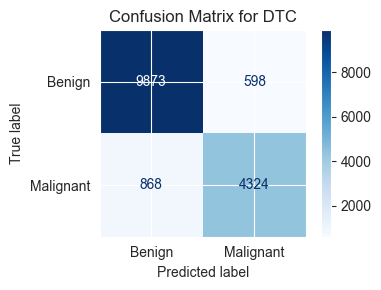

'Performance metrics for LR model'

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     10471
           1       0.89      0.84      0.86      5192

    accuracy                           0.91     15663
   macro avg       0.91      0.89      0.90     15663
weighted avg       0.91      0.91      0.91     15663



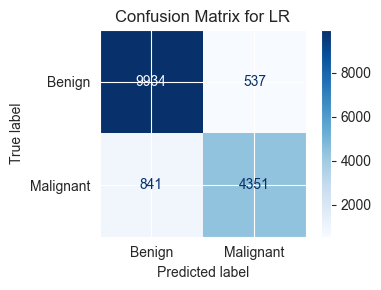

'Performance metrics for XGBClassifier model'

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10471
           1       0.89      0.85      0.87      5192

    accuracy                           0.92     15663
   macro avg       0.91      0.90      0.91     15663
weighted avg       0.92      0.92      0.92     15663



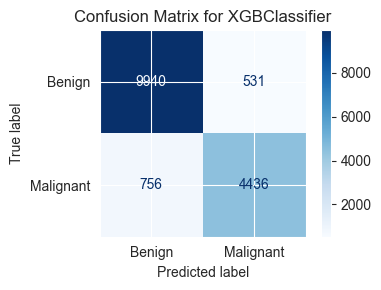

'Performance metrics for GaussianNB model'

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     10471
           1       0.76      0.90      0.82      5192

    accuracy                           0.87     15663
   macro avg       0.85      0.88      0.86     15663
weighted avg       0.88      0.87      0.87     15663



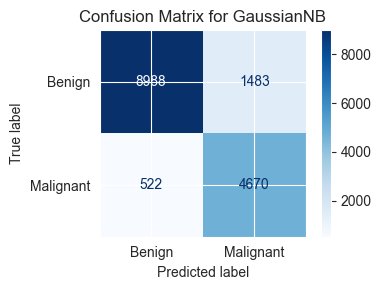

In [17]:

models_perfmance_df_test = pd.DataFrame()
display("Validation : models confusion matrixes:")
models_perfmance_df_test = validate_models(models_perfmance_df_test,X_test, y_test)

In [36]:
# fine tune models parameters
# use customized refit_strategy to select the best estimator
def fine_tune_model(model , X_train, y_train, X_test, y_test, params):
    grid_search = GridSearchCV(model, params, refit = refit_strategy, scoring= scores, verbose= 1, n_jobs= -1)                                              
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"Best parameters for the { type(model).__name__  } after fine tuning: {best_params}")
    y_test_pred = grid_search.best_estimator_.predict(X_test)
    cls_rprt = classificationMetrics(y_test, y_test_pred)
    print(classification_report(y_test, y_test_pred))
    print(cls_rprt)
    display(confusion_matrix(y_test, y_test_pred))
    return grid_search.best_estimator_ , cls_rprt


# Fine tune XGBClassifier

In [48]:
import warnings
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report

# Suppress all warnings
warnings.filterwarnings('ignore')

# Define the parameter grid (without 'n_jobs')
tuned_parameters_XGBClassifier = {
    'n_estimators': [200, 300],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'alpha': [0, 0.1, 0.5],
    'lambda': [1, 1.5, 2]
}

# Define the model with early stopping and verbosity directly in the constructor
model = xgb.XGBClassifier(
    early_stopping_rounds=10,  # Set early stopping here
    verbosity=0  # Suppress output
)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=tuned_parameters_XGBClassifier,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring='accuracy',  # Metric to optimize
    n_jobs=-1,  # Use all available cores for parallel processing
    cv=5,  # 5-fold cross-validation
    verbose=3,
    random_state=42
)

# Fit the model without passing early stopping in fit method
random_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False  # Suppress the detailed per-iteration output
)

# Retrieve the best estimator
best_model = random_search.best_estimator_

# Predict and evaluate on the test set
y_pred = best_model.predict(X_test)
clf_report_xgbc = classification_report(y_test, y_pred)

# Print the best parameters and the classification report
print("Best Parameters:", random_search.best_params_)
print(clf_report_xgbc)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 1, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 0.9, 'alpha': 0}
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10471
           1       0.89      0.86      0.87      5192

    accuracy                           0.92     15663
   macro avg       0.91      0.90      0.91     15663
weighted avg       0.92      0.92      0.92     15663



Confusion Matrix:
 [[9920  551]
 [ 750 4442]]


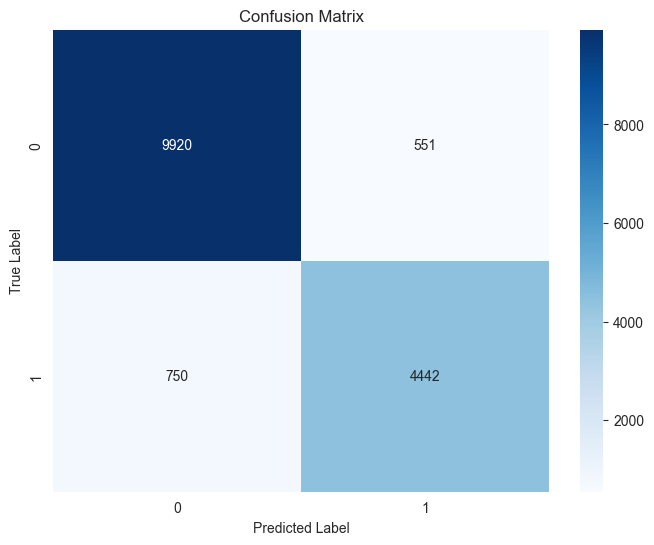

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred is the predicted labels
cm = confusion_matrix(y_test, y_pred)

# Optionally, you can print the confusion matrix as a raw array
print("Confusion Matrix:\n", cm)

# Visualizing the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
